# Book Recommendation Engine

In [1]:
# Importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from sklearn.neighbors import NearestNeighbors
import sklearn.metrics as metrics
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import correlation

import ipywidgets as widgets
from contextlib import contextmanager
import os, sys
import re
from IPython.display import display, clear_output

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', -1)

In [2]:
# Importação das bibliotecas
livros = pd.read_csv('BX-Books.csv', sep = ';', error_bad_lines = False, encoding = "latin-1")
usuarios = pd.read_csv('BX-Users.csv', sep = ';', error_bad_lines = False, encoding = "latin-1")
avaliacoes = pd.read_csv('BX-Book-Ratings.csv', sep = ';', error_bad_lines = False, encoding = "latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [3]:
# Verifica o shape dos datasets
print('Livros: ' + str(livros.shape))
print('Usuários: ' + str(usuarios.shape))
print('Avaliações: ' + str(avaliacoes.shape))

Livros: (271360, 8)
Usuários: (278858, 3)
Avaliações: (1149780, 3)


# Exploração do dataset de Livros

In [4]:
livros.sample(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
5617,8807701189,Garzanti - Gli Elefanti: Il Capitano E' Fuori a Pranzo,Bukowski,0,Feltrinelli,http://images.amazon.com/images/P/8807701189.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/8807701189.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/8807701189.01.LZZZZZZZ.jpg
176252,014030665X,A Book of Bosh (Puffin Books),Edward Lear,1975,Puffin Books,http://images.amazon.com/images/P/014030665X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/014030665X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/014030665X.01.LZZZZZZZ.jpg
139012,1853261238,The Happy Prince &amp; Other Stories,Oscar Wilde,1999,Wordsworth Editions Ltd,http://images.amazon.com/images/P/1853261238.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1853261238.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1853261238.01.LZZZZZZZ.jpg


In [5]:
# Deletando as colunas que não serão utilizadas no algoritmo
livros = livros.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis = 1)

In [6]:
livros.sample(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
195643,0786004398,Going Postal,Don Lasseter,1997,Pinnacle Books
97834,044920510X,Rainsong,Phyllis A. Whitney,1988,Ivy Books
259318,0681220791,Oscar Wilde Reader,Oscar Wilde,0,Hunter Publishing+inc


In [7]:
# Verifica o tipo dos dados
livros.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
dtype: object

### Year-Of-Publication

In [8]:
# Verifica os valores unicos
livros['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Como podemos ver, existem algumas entradas incorretas nessa variável, 'DK Publishing Inc' e 'Gallimard' foram carregados incorretamente como Year-Of-Publication no dataset devido a alguns erros no arquivo csv

In [9]:
# Investigando as linhas onde o ano de publicação está como 'DK Publishing Inc'.
livros[livros['Year-Of-Publication'] == 'DK Publishing Inc']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


Os dados estão totalmente bagunçados por conta do CSV, por conta disso, iremos realizar as alterações manualmente

In [10]:
# Livro 0789466953 
livros.loc[livros['ISBN'] == '0789466953','Year-Of-Publication'] = 2000
livros.loc[livros['ISBN'] == '0789466953','Book-Author'] = "James Buckley"
livros.loc[livros['ISBN'] == '0789466953','Publisher'] = "DK Publishing Inc"
livros.loc[livros['ISBN'] == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [11]:
# Livro 078946697X
livros.loc[livros['ISBN'] == '078946697X','Year-Of-Publication'] = 2000
livros.loc[livros['ISBN'] == '078946697X','Book-Author'] = "Michael Teitelbaum"
livros.loc[livros['ISBN'] == '078946697X','Publisher'] = "DK Publishing Inc"
livros.loc[livros['ISBN'] == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [12]:
# Verifica o resultado
livros.loc[(livros['ISBN'] == '0789466953') | (livros['ISBN'] == '078946697X'),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc


In [13]:
# Investigando as linhas onde o ano de publicação está como 'Gallimard'
livros.loc[livros['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [14]:
# Realiza a correção
livros.loc[livros['ISBN'] == '2070426769','Year-Of-Publication'] = 2003
livros.loc[livros['ISBN'] == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
livros.loc[livros['ISBN'] == '2070426769','Publisher'] = "Gallimard"
livros.loc[livros['ISBN'] == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"

In [15]:
# Verifica o resultado
livros.loc[livros['ISBN'] == '2070426769',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


In [16]:
# Converte o ano de publicação em inteiro
livros['Year-Of-Publication'] = livros['Year-Of-Publication'].astype(int)

In [17]:
livros['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984,    0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378,
       1919, 1922, 1897, 2024, 1376, 2037])

Além do valor 0, considerei como sujeira nos dados os livros publicados após 2005, uma vez que o dataset é de 2004

In [18]:
livros.loc[(livros['Year-Of-Publication'] > 2006) | (livros['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.NAN

In [19]:
# Preenche os valores com o ano médio
livros['Year-Of-Publication'] = livros['Year-Of-Publication'].fillna(round(livros['Year-Of-Publication'].mean())).astype(int)

In [20]:
sorted(livros['Year-Of-Publication'].unique())

[1376,
 1378,
 1806,
 1897,
 1900,
 1901,
 1902,
 1904,
 1906,
 1908,
 1909,
 1910,
 1911,
 1914,
 1917,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006]

### Publisher

In [21]:
# Verifica se temos itens com Publisher null
livros['Publisher'].isnull().sum()

2

In [22]:
livros[livros['Publisher'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [23]:
# Preenche com 'outros'
livros['Publisher'] = np.where(livros['Publisher'].isnull(), 'outros', livros['Publisher'])

## Dataset Usuarios

In [24]:
print(usuarios.shape)
usuarios.head()

(278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [25]:
# Tipos de dados
usuarios.dtypes

User-ID     int64  
Location    object 
Age         float64
dtype: object

### Idade

In [26]:
print(sorted(usuarios['Age'].unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Possuímos muitas sujeiras na idade dos usuários, portanto irei considerar como sujeira todos os valores acima de 85 e abaixo de 6 anos.

In [27]:
usuarios.loc[(usuarios['Age'] >= 86) | (usuarios['Age'] <= 5), 'Age'] = np.nan

In [28]:
usuarios['Age'] = np.where(usuarios['Age'].isnull(), usuarios['Age'].mean(), usuarios['Age'])

In [29]:
print(sorted(usuarios['Age'].unique()))

[6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 34.721493858554844, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0]


## Dataset Avaliações

In [30]:
avaliacoes.shape

(1149780, 3)

O conjunto de dados terá n_usuarios * n_livros entradas se todos os usuários classificaram cada item, isso mostra que o conjunto de dados é muito espesso.

In [31]:
n_usuarios = usuarios.shape[0]
n_livros = livros.shape[0]
print(n_usuarios * n_livros)

75670906880


In [32]:
avaliacoes.sample(5)

,User-ID,ISBN,Book-Rating
453147,108551,2070393895,9
911983,222173,3442447038,7
403709,97636,1400034779,0
103930,23902,0140422161,8
191915,42466,0060926880,0


In [33]:
# Verificamos se o conjunto possui notas de 0 a 10
sorted(avaliacoes['Book-Rating'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Garantirei que o dataset de avaliações contenha apenas os livros que possuimos no dataset de livros.

In [34]:
avaliacoes_fim = avaliacoes[avaliacoes['ISBN'].isin(livros['ISBN'])]

In [35]:
print('Livros removidos: ' + str(avaliacoes['ISBN'].count() - avaliacoes_fim['ISBN'].count()))

Livros removidos: 118644


In [36]:
print('Número de usuários: ' + str(n_usuarios))
print('Número de livros : ' + str(n_livros))

Número de usuários: 278858
Número de livros : 271360


O dataset contém informações da avaliação dos livros, avaliações são explicitas quando estão em escala de 1 a 10, e implícitas quando em escala 0

In [37]:
avaliacoes_explicitas = avaliacoes_fim[avaliacoes_fim['Book-Rating'] != 0]
avaliacoes_implicitas = avaliacoes_fim[avaliacoes_fim['Book-Rating'] == 0]

In [38]:
# Verificando o shape dos dados
print('Base Avaliações :' + str(avaliacoes_fim.shape))
print('Avaliações Explícitas: ' + str(avaliacoes_explicitas.shape))
print('Avaliações Implícitas: ' + str(avaliacoes_implicitas.shape))

Base Avaliações :(1031136, 3)
Avaliações Explícitas: (383842, 3)
Avaliações Implícitas: (647294, 3)


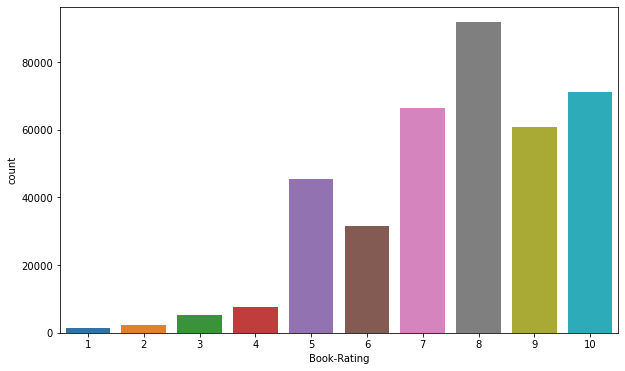

In [39]:
# Plot das avaliações explícitas
plt.figure(figsize = (10, 6))
sns.countplot(avaliacoes_explicitas['Book-Rating'])

Pode-se observar que as avaliações mais altas são mais comuns entre os usuários e a nota 8 foi classificada o maior número de vezes

---

# SISTEMA DE RECOMENDAÇÃO BASEADO EM POPULARIDADE

---

Neste ponto, um sistema simples de recomendação baseado em popularidade pode ser construído com base na soma das avaliações de usuários para livros diferentes

In [40]:
contagem_avaliacoes = pd.DataFrame(avaliacoes_explicitas.groupby(['ISBN'])['Book-Rating'].sum())
top10 = contagem_avaliacoes.sort_values('Book-Rating', ascending = False).head(10)
print('Recomendação dos seguintes livros:')
top10.merge(livros, left_index = True, right_on = 'ISBN')

Recomendação dos seguintes livros:


,Book-Rating,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


---

# SISTEMA DE RECOMENDAÇÃO BASEADO EM FILTRO COLABORATIVO

---

Por conta do poder computacional que possuo e para reduzir o tamanho do conjunto de dados, estou considerando usuários que avaliaram pelo menos 100 livros e livros com pelo menos 100 avaliações

In [41]:
counts1 = avaliacoes_explicitas['User-ID'].value_counts()
avaliacoes_explicitas = avaliacoes_explicitas[avaliacoes_explicitas['User-ID'].isin(counts1[counts1 >= 100].index)]

counts = avaliacoes_explicitas['Book-Rating'].value_counts()
avaliacoes_explicitas = avaliacoes_explicitas[avaliacoes_explicitas['Book-Rating'].isin(counts[counts >= 100].index)]

Gera a matriz de avaliações a partir da tabela de avaliações explícitas

In [42]:
matriz_avaliacoes = avaliacoes_explicitas.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
userID = matriz_avaliacoes.index
ISBN = matriz_avaliacoes.columns
print('Shape da matriz de avaliação: ' + str(matriz_avaliacoes.shape)); print('\n')

matriz_avaliacoes = matriz_avaliacoes.fillna(0)
matriz_avaliacoes.sample(5)

Shape da matriz de avaliação: (449, 66574)




ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
User-ID,,,,,,,,,,,,,,,,,,,,,
229551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Treinamento do sistema de recomendação

In [43]:
# Definindo as variáveis globais
global metric,k
k = 10
metric = 'cosine'

### Recomendação baseada no usuário

Esta função encontra k usuários semelhantes dado o id de usuário e a matriz de avaliações.
Estas similaridades são as mesmas que as obtidas por meio do pairwise_distances

In [44]:
def findksimilarusers(user_id, ratings, metric = metric, k = k):
    similarities = []
    indices = []
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1 - distances.flatten()
            
    return similarities,indices

Esta função prediz a avaliação para a combinação especificada de usuário-item com base na abordagem baseada no usuário

In [45]:
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices = findksimilarusers(user_id, ratings,metric, k)
    mean_rating = ratings.iloc[user_loc,:].mean()
    sum_wt = np.sum(similarities)-1
    product = 1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    # no caso de conjuntos de dados muito esparsos, o uso da métrica de correlação para uma abordagem colaborativa pode dar classificações negativas
    # onde o tratamento está abaixo
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print('\nAvaliação prevista para o usuário {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

In [46]:
# Usuário / Livro / Avaliação
predict_userbased(11676, '0671027360', matriz_avaliacoes);


Avaliação prevista para o usuário 11676 -> item 0671027360: 2


### Recomendação baseada em ites

In [47]:
def findksimilaritems(item_id, ratings, metric = metric, k = k):
    similarities = []
    indices = []
    ratings = ratings.T
    loc = ratings.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

In [48]:
similarities, indices = findksimilaritems('0001056107', matriz_avaliacoes)

In [49]:
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings)
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    
    # no caso de conjuntos de dados muito esparsos, o uso da métrica de correlação para uma abordagem colaborativa pode dar classificações negativas
    # onde o tratamento está abaixo
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10

    print('\nAvaliação prevista para o usuário {0} -> item {1}: {2}'.format(user_id,item_id,prediction)      )
    
    return prediction

In [50]:
prediction = predict_itembased(11676, '0671027360', matriz_avaliacoes)


Avaliação prevista para o usuário 11676 -> item 0671027360: 2


In [51]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

Essa função utiliza as funções acima para recomendar itens nas abordagens baseadas em item / usuário e cosseno / correlação.

Recomendações são feitas se a avaliação prevista para um item for >= a 6 e os itens ainda não tiverem sido classificados.

In [52]:
def recommendItem(user_id, ratings, metric=metric):    
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print("O Usuário deve estar nesta lista :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(matriz_avaliacoes.index.values))))
    else:
        ids = ['Item-based (correlation)','Item-based (cosine)','User-based (correlation)','User-based (cosine)']
        select = widgets.Dropdown(options = ids, value = ids[0], description = 'Selecione a abordagem', width='1000px')
        def on_change(change):
            clear_output(wait = True)
            prediction = []            
            if change['type'] == 'change' and change['name'] == 'value':            
                if (select.value == 'Item-based (correlation)') | (select.value == 'User-based (correlation)') :
                    metric = 'correlation'
                else:                       
                    metric = 'cosine'   
                with suppress_stdout():
                    if (select.value == 'Item-based (correlation)') | (select.value == 'Item-based (cosine)'):
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0):
                                prediction.append(predict_itembased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1)
                    else:
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0):
                                prediction.append(predict_userbased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1)
                prediction = pd.Series(prediction)
                prediction = prediction.sort_values(ascending=False)
                recommended = prediction[:10]
                print("De acordo com a abordagem {0}, recomenda-se os seguintes livros: ".format(select.value))
                for i in range(len(recommended)):
                    print("{0}. {1}".format(i+1, livros['Book-Title'][recommended.index[i]].encode('utf-8')))                    
        select.observe(on_change)
        display(select)

In [53]:
recommendItem(999999, matriz_avaliacoes)

O Usuário deve estar nesta lista :

   2033   2110   2276   4017   4385   5582   6242   6251   6543   6575
   7286   7346   8067   8245   8681   8890  10560  11676  11993  12538
  12824  12982  13552  13850  14422  15408  15418  16634  16795  16966
  17950  19085  21014  23768  23872  23902  25409  25601  25981  26535
  26544  26583  28591  28634  29259  30276  30511  30711  30735  30810
  31315  31556  31826  32773  33145  35433  35836  35857  35859  36299
  36554  36606  36609  36836  36907  37644  37712  37950  38023  38273
  38281  39281  39467  40889  40943  43246  43910  46398  47316  48025
  48494  49144  49889  51883  52199  52350  52584  52614  52917  53220
  55187  55490  55492  56271  56399  56447  56554  56959  59172  60244
  60337  60707  63714  63956  65258  66942  67840  68555  69078  69389
  69697  70415  70594  70666  72352  73681  75591  75819  76151  76223
  76499  76626  78553  78783  78834  78973  79441  81492  81560  83287
  83637  83671  85526  85656  86189  8694

In [54]:
recommendItem(36836, matriz_avaliacoes)

Dropdown(description='Selecione a abordagem', options=('Item-based (correlation)', 'Item-based (cosine)', 'Use…

De acordo com a abordagem Item-based (cosine), recomenda-se os seguintes livros: 
1. b"Disney's the Lion King (Little Golden Book)"
2. b'Jaguar Smile'
3. b'The Claw'
4. b'The Outcast (Griffin Saga; Vol. 1)'
5. b'The Woman in White (Classics)'
6. b'Negotiator'
7. b'The Last Duke'
8. b'Rabbit, Run'
9. b'The Sonnets: An Illustrated Edition'
10. b'Outpost (Wagons West Frontier Trilogy)'

In [55]:
recommendItem(36836, matriz_avaliacoes)

Dropdown(description='Selecione a abordagem', options=('Item-based (correlation)', 'Item-based (cosine)', 'Use…

De acordo com a abordagem User-based (correlation), recomenda-se os seguintes livros: 
1. b'The Big Four'
2. b'War With the Newts'
3. b'I Am Dracula/Know Me'
4. b'My Lady Notorious'
5. b'Free Money: From Colleges and Universities'
6. b'The Rise and  Fall of the American Teenager'
7. b'Digging Your Own Grave'
8. b'Bad Moon Rising (Silhouette Intimate Moments, No. 412)'
9. b"Disney's the Lion King (Little Golden Book)"
10. b'Protecting Your Life, Home, and Property: A Cop Shows You How'